<h1 style="color:SteelBlue; font-size:200%; line-height:1.5">Модель для прогноза количества заказов такси на следующий час</h1>

Задача: построить модель для прогноза количества заказов такси на следующий час. Есть исторические данные о количестве заказов такси в разное время. 

Цель: оптимизировать количество водителей в период пиковой нагрузки

Целевая метрика: RMSE (на тестовой выборке должно быть не больше 48).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.dummy import DummyRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def cross_val_timeseries(model, X, y, metric='rmse', n_splits = 5):
    """
    Функция для кроссвалидации с cross_validator = TimeSeriesSplit()
    model - модель
    X - матрица признаков
    y - вектор целевого признака
    metric - метрика (mae, rmse, r2)
    n_splits - число разбиений
    """
    _model = model
    score_list = []
    features = X.copy()
    targets = y.copy()
    cross_validator = TimeSeriesSplit()
    
    for train_index, valid_index in cross_validator.split(features, targets):
        
        train_index = features.index[train_index]
        valid_index = features.index[valid_index]

        features_train, features_valid = features.loc[train_index,:], features.loc[valid_index,:]
        targets_train, targets_valid = targets[train_index], targets[valid_index]
        
        _model.fit(features_train, targets_train)
        predictions = _model.predict(features_valid)
        
        if metric == 'mae':
            score = mean_absolute_error(targets_valid, predictions)
        elif metric == 'rmse':
            score = np.sqrt(mean_squared_error(targets_valid, predictions))
        elif metric == 'r2':
            score = r2_score(targets_valid, predictions)
            
        score_list.append(score)
        
    return score_list

In [3]:
def model_train_test(model, X_train, X_test, y_train, y_test, metric='rmse'):
    """
    Функция для вывода на экран метрики, полученной на трейне и тесте
    X_train, X_test - матрицы признаков
    y_train, y_test - векторы целевого признака
    metric - метрика (mae, rmse, r2)
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print('Предсказание:')
    if metric == 'mae':
        score_valid = mean_absolute_error(y_train, y_train_pred)
        score_test = mean_absolute_error(y_test, y_test_pred)
    elif metric == 'rmse':
        score_valid = np.sqrt(mean_squared_error(y_train, y_train_pred))
        score_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    elif metric == 'r2':
        score_valid = r2_score(y_train, y_train_pred)
        score_test = r2_score(y_test, y_test_pred)
    print(f"{metric} обучающей выборки:", score_valid )
    print(f"{metric} тестовой выборки: ", score_test )

In [4]:
test_size = 0.1

<h1 style="color:SteelBlue"> 1. Загрузка, общая информация о данных</h1>

In [5]:
link = 'C:/Users/Affernus/JupiterNotebooks/datasets/ML/'
df = pd.read_csv(link+'taxi.csv', 
                parse_dates=['datetime']
                )

In [6]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [8]:
df.duplicated().sum()

0

In [9]:
df.set_index('datetime', drop=True, inplace=True)
df.sort_index(inplace=True)
df.index.name = None
df.head()

,num_orders
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
print(df.index.is_monotonic)

True


In [11]:
print('start:', df.index.min(), 'end:', df.index.max())

start: 2018-03-01 00:00:00 end: 2018-08-31 23:50:00


Посмотрим на график ряда:

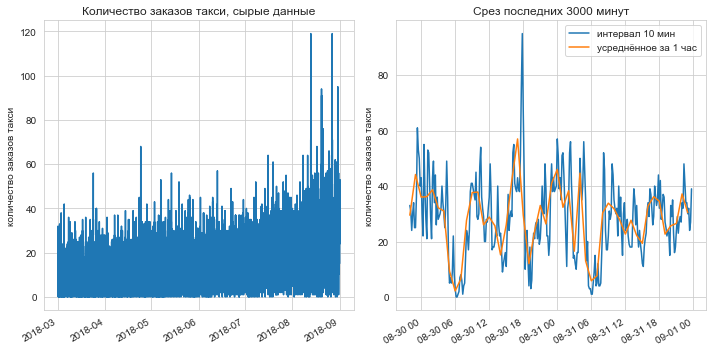

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].plot(df)
ax[0].set_title('Количество заказов такси, сырые данные')
ax[1].plot(df.iloc[-300:-1,:], label='интервал 10 мин')
ax[1].plot(df.iloc[-300:-1,:].resample('1H').mean(), label='усреднённое за 1 час')
ax[1].set_title('Срез последних 3000 минут')
ax[1].legend()
for axes in ax:
    axes.set_ylabel('количество заказов такси')
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.tight_layout()
plt.show()

На графике сырых данных мало что можно разобрать. На фрагменте последних 300 минут видно, что в значениях, полученных на 10 минутных интервалах есть выбросы. К тому же по условию прогноз нужно сделать на следующий час. Поэтому имеет смысл перейти сразу к почасовому интервалу и суммарному количеству заказов на этом интервале.

In [13]:
df = df.resample('1H').sum()

Рассмотрим, есть ли тренды и сезонность.

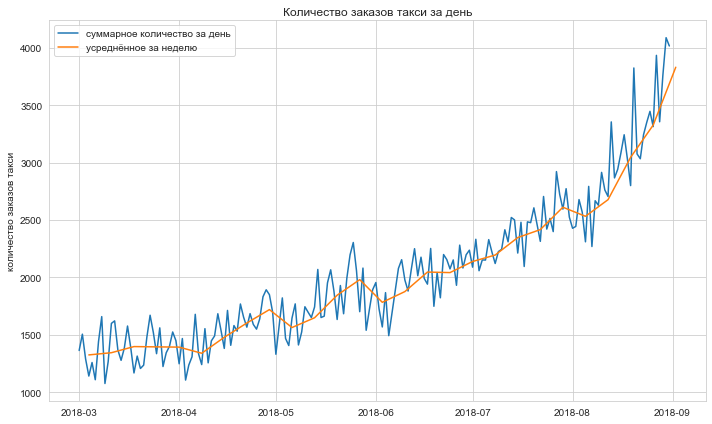

In [14]:
plt.figure(figsize=(10,6))
plt.title('Количество заказов такси за день')
plt.plot(df.resample('1d').sum(), label='суммарное количество за день')
plt.plot(df.resample('1d').sum().resample('1w').mean(), label='усреднённое за неделю')

plt.ylabel('количество заказов такси')
plt.legend()
plt.tight_layout()
plt.show()

График имеет выраженный тренд, соответственно, наш временной ряд - нестационарный. Посмотрим, есть ли сезонность. Ожидаемо, что она есть, т.к. количество заказов наверняка меняется в зависимости от времени суток и дней недели.

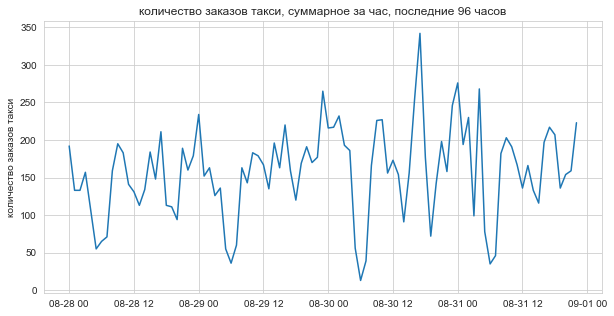

In [15]:
plt.figure(figsize=(10,5))
plt.plot(df.iloc[-96:-1,:])
plt.title('количество заказов такси, суммарное за час, последние 96 часов')
plt.ylabel('количество заказов такси')
plt.show()

Видно, что в утренние часы число заказов падает. По времени суток сезонность проявляется. Посмотрим, что по дням недели:

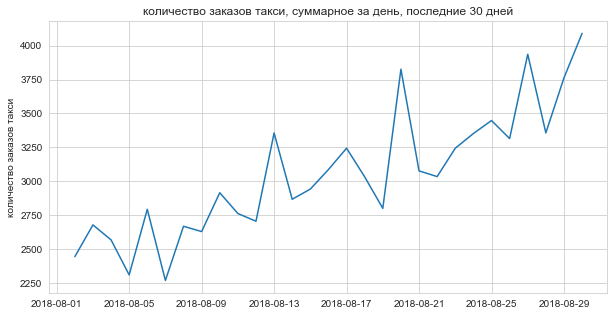

In [16]:
plt.figure(figsize=(10,5))
plt.plot(df.resample('1d').sum().iloc[-30:-1,:])
plt.title('количество заказов такси, суммарное за день, последние 30 дней')
plt.ylabel('количество заказов такси')
plt.show()

Тоже наблюдаются пики каждые несколько дней.

Итак, наши данные - это временной ряд с выраженным трендом и сезонностью. Пробую выполнить декомпозицию временного ряда.

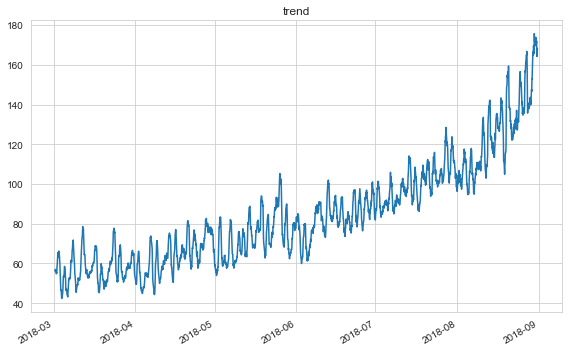

In [17]:
decompose_additive = seasonal_decompose(df, model='additive')
fig, axs  = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
axs.set_title('trend')
axs.plot(decompose_additive.trend)
fig.autofmt_xdate()
plt.tight_layout()

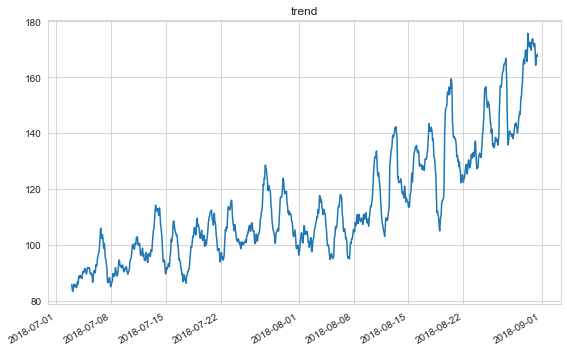

In [18]:
fig, axs  = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
axs.set_title('trend')
axs.plot(decompose_additive.trend.iloc[-24*60:-1])
fig.autofmt_xdate()
plt.tight_layout()

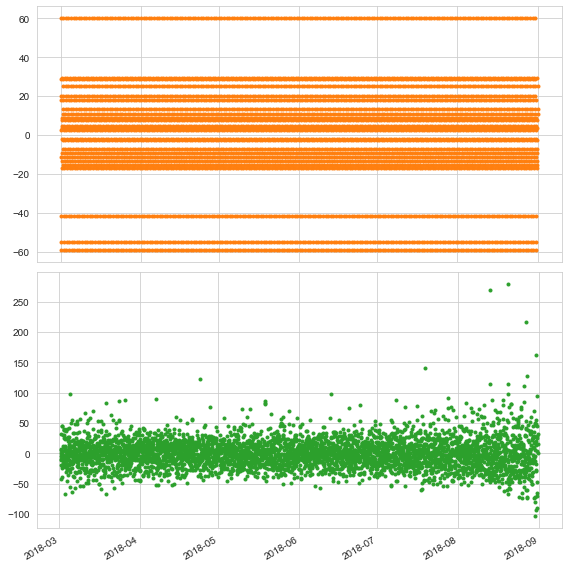

In [19]:
decompose_mult = seasonal_decompose(df['num_orders']+1, model='multiplicative')
fig, axs  = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
axs[0].plot(decompose_additive.seasonal, '.', c=sns.color_palette()[1])
axs[1].plot(decompose_additive.resid, '.', c=sns.color_palette()[2])
fig.autofmt_xdate()
plt.tight_layout()

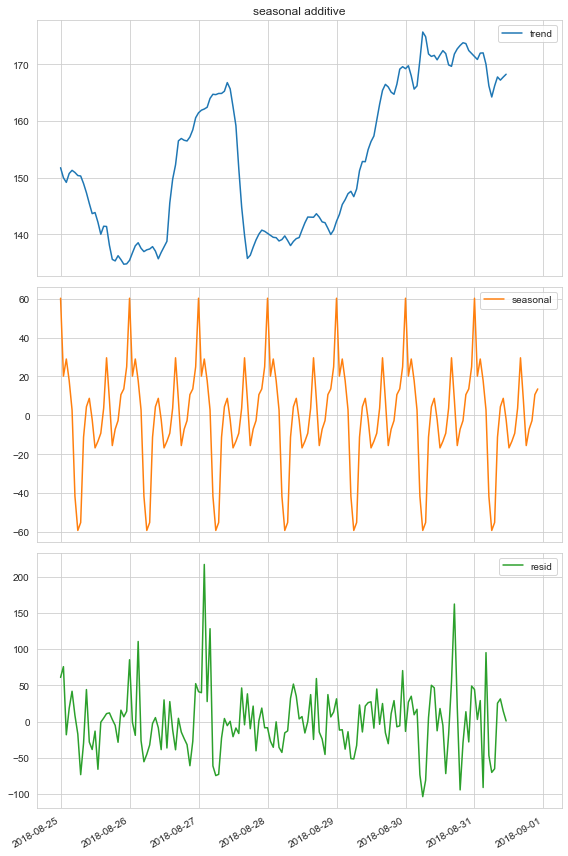

In [20]:
last_days = 7
fig, axs  = plt.subplots(nrows=3, ncols=1, figsize=(8,12), sharex=True)
axs[0].set_title('seasonal additive')
axs[0].plot(decompose_additive.trend.iloc[-24*last_days:-1], c=sns.color_palette()[0], label='trend')
axs[1].plot(decompose_additive.seasonal.iloc[-24*last_days:-1], c=sns.color_palette()[1], label='seasonal')
axs[2].plot(decompose_additive.resid.iloc[-24*last_days:-1], c=sns.color_palette()[2], label='resid')
for ax in axs:
    ax.legend()
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

Аддитивная модель выделяет тренд, сезонную компоненту и остатки. Тренд одинаковый, вид сезонной компоненты одинаковый (амплитуда разная), остатки отличаются по виду и разбросу. Тренд держится примерно постоянным 1-2 дня, затем скачкообразно меняется. Т.е., на самом деле, у нас две сезонности. Сезонная компонента чётко повторяется с периодом сутки.

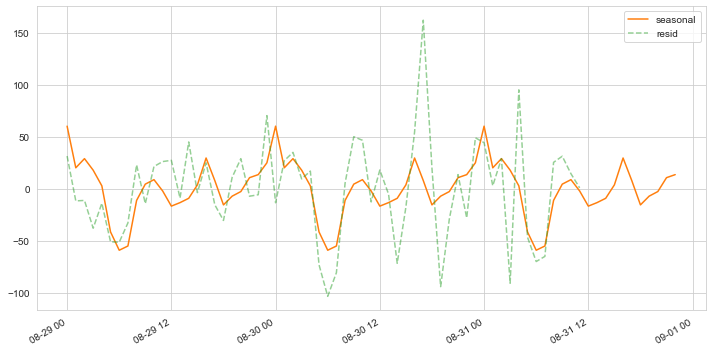

In [21]:
fig = plt.figure(figsize=(10,5))
plt.plot(decompose_additive.seasonal.iloc[-72:-1], label='seasonal', c=sns.color_palette()[1])
plt.plot(decompose_additive.resid.iloc[-72:-1], '--', label='resid', c=sns.color_palette()[2], alpha=0.5)
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

В сезонной компоненте наблюдается 24 часовая периодичность. Т.е. по идее 24 лаг в признаках должен сработать. Посмотрю СКО разностей за 7 суток:

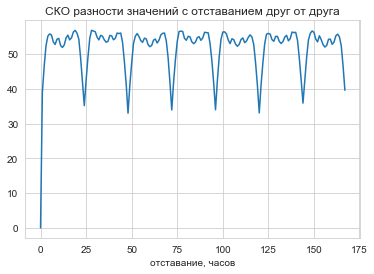

In [22]:
lags = []
for i in range(0,24*7):
    lags.append(df['num_orders'].diff(i).std())
plt.plot(lags)
plt.title('СКО разности значений с отставанием друг от друга')
plt.xlabel('отставание, часов')
plt.show()

И действительно, СКО разности со значением 24 - одно из самых низких. Но, что интересно, разность со значением 48 даёт СКО ниже, чем 24. Посмотрю автокорреляции:

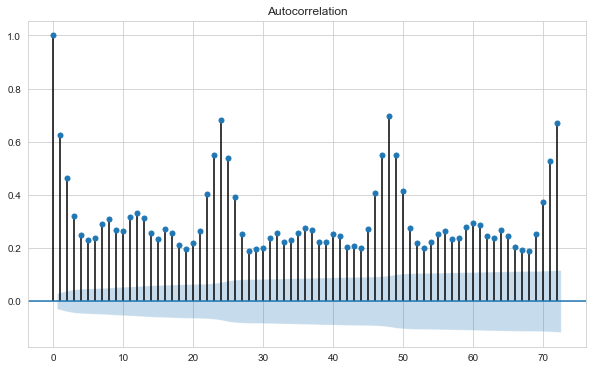

In [23]:
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
acf = plot_acf(df['num_orders'], lags=72, ax=ax)

Получается, 1, 24 и далее - коэффициент автокорреляции более 0.6.

Проведу поиск оптимального размера скользящего окна для предсказания trend:

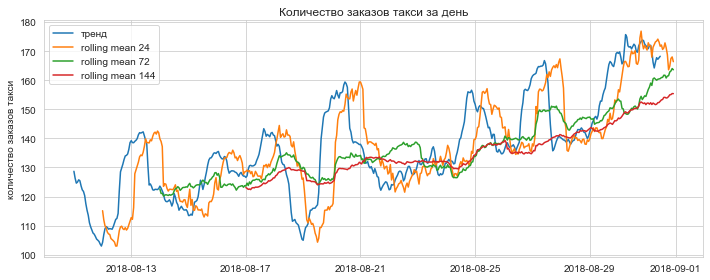

In [24]:
plt.figure(figsize=(10,4))
plt.title('Количество заказов такси за день')
plt.plot(decompose_additive.trend.iloc[-7*72:-1], label='тренд')
plt.plot(df.iloc[-7*72:-1, 0].shift().rolling(24).mean(), label='rolling mean 24')
plt.plot(df.iloc[-7*72:-1, 0].shift().rolling(72).mean(), label='rolling mean 72')
plt.plot(df.iloc[-7*72:-1, 0].shift().rolling(144).mean(), label='rolling mean 144')
plt.ylabel('количество заказов такси')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
df_trend_prediction = pd.DataFrame()
df_trend_prediction.loc[:, 'trend'] = decompose_additive.trend
for i in [24*k for k in range(1,8)]:
    df_trend_prediction.loc[:, f'rolling_{i}'] = df.shift().rolling(i).mean()
df_trend_prediction.loc[:, f'rolling_12'] = df.shift().rolling(12).mean()

Корреляционный анализ взаимосвязи trend vs rolling mean:

In [26]:
df_trend_prediction.dropna()
df_trend_prediction.corr(method='spearman')

,trend,rolling_24,rolling_48,rolling_72,rolling_96,rolling_120,rolling_144,rolling_168,rolling_12
trend,1.000000,0.937303,0.925758,0.931995,0.924729,0.931440,0.922448,0.926390,0.906706
rolling_24,0.937303,1.000000,0.963305,0.956190,0.948211,0.944171,0.943379,0.933620,0.908971
rolling_48,0.925758,0.963305,1.000000,0.986255,0.981405,0.976484,0.975190,0.971099,0.867638
rolling_72,0.931995,0.956190,0.986255,1.000000,0.991686,0.988413,0.985852,0.983302,0.870783
rolling_96,0.924729,0.948211,0.981405,0.991686,1.000000,0.994219,0.992323,0.989051,0.859695
rolling_120,0.931440,0.944171,0.976484,0.988413,0.994219,1.000000,0.996091,0.993592,0.861307
rolling_144,0.922448,0.943379,0.975190,0.985852,0.992323,0.996091,1.000000,0.996548,0.855415
rolling_168,0.926390,0.933620,0.971099,0.983302,0.989051,0.993592,0.996548,1.000000,0.849840
rolling_12,0.906706,0.908971,0.867638,0.870783,0.859695,0.861307,0.855415,0.849840,1.000000


Самая высокая корреляция тренда (выделенного при декомпозиции) - со средними по скользящему окну 24, это видно и на графике. Запаздывает, но точно воспроизводит тренд. Если нет перепада, то достаточно точно повторяет.
Т.е., получается, значение тренда можно прогнозировать по среднему для скользящего окна размером 24. Для часов в сутках можно посмотреть среднюю разность между этим значением среднего скользящего окна и количеством заказом и добавить её как признак. Соответственно, для каждого часа корректировать тренд средним отличием от трейна. 

Добавлю признаки:

In [27]:
df.loc[: ,'rolling_24_mean'] = df['num_orders'].shift().rolling(24).mean()

In [28]:
df.loc[: ,'trend_hour_diff'] = df['num_orders'] - df['rolling_24_mean']

Также добавлю признаки "час" и "день недели":

In [29]:
df.loc[: ,'hour'] = df.index.hour
df.loc[: ,'weekday'] = df.index.weekday

In [30]:
df.head()

,num_orders,rolling_24_mean,trend_hour_diff,hour,weekday
2018-03-01 00:00:00,124,NaN,NaN,0,3
2018-03-01 01:00:00,85,NaN,NaN,1,3
2018-03-01 02:00:00,71,NaN,NaN,2,3
2018-03-01 03:00:00,66,NaN,NaN,3,3
2018-03-01 04:00:00,43,NaN,NaN,4,3


Посмотрю, есть ли различия в среднем числе заказов в зависимости от часа дня и дня недели. Анализировать буду разность среднего за час/день и скользящего среднего за 24 часа.

In [31]:
df.groupby('hour')['trend_hour_diff'].mean()

hour
0     60.544399
1     20.466075
2     29.271858
3     18.153689
4      3.075137
5    -41.293033
6    -58.894126
7    -54.795537
8    -10.890027
9      4.753871
10     9.062158
11    -1.830146
12   -16.425546
13   -12.897769
14    -9.004781
15     3.729964
16    30.188525
17     8.607013
18   -15.082650
19    -6.938297
20    -2.500000
21    10.877732
22    13.905738
23    25.509107
Name: trend_hour_diff, dtype: float64

Отличия видны! Вообще, можно часы закодировать OHE и модель сама им подберёт оптимальные веса на базе значения среднего по скользящему окну 24. Либо можно закодировать этими средними.

По дням недели также есть различия:

In [32]:
df.groupby('weekday')['trend_hour_diff'].mean()

weekday
0    0.793336
1   -3.203392
2    4.083801
3   -0.003072
4    5.597672
5   -7.180155
6    1.923411
Name: trend_hour_diff, dtype: float64

В предварительных тестах OHE показал плохо. Поэтому закодировал часы и дни недели усреднённым (по трейну) для них значением разности количества заказов и rolling_24_mean.

Ещё попробую добавить признак, который будет показывать, увеличивалось число заказов в последние 2 часа или нет. Для этого возьму разность между числом заказов 1 час назад и 2 часа назад и добавлю эту разность в признаки текущего объекта. Если разность отрицательная, значит число заказов падает. Если положительная - растёт. Фактически, по принципу первой производной. Можно ещё взять вторую, которая покажет скорость роста. Разность разности. Чтобы избежать утечки, сдвину их на единицу.

In [33]:
df.loc[:, 'diff_1'] = df['num_orders'].diff(1).shift()
df.loc[:, 'diff_2'] = df['diff_1'].diff(1).shift()

In [34]:
display(df.head())
display(df.tail())

,num_orders,rolling_24_mean,trend_hour_diff,hour,weekday,diff_1,diff_2
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,-39.0,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,-14.0,NaN
2018-03-01 04:00:00,43,NaN,NaN,4,3,-5.0,25.0


,num_orders,rolling_24_mean,trend_hour_diff,hour,weekday,diff_1,diff_2
2018-08-31 19:00:00,136,164.875000,-28.875000,19,4,-10.0,-61.0
2018-08-31 20:00:00,154,167.541667,-13.541667,20,4,-71.0,-30.0
2018-08-31 21:00:00,159,168.041667,-9.041667,21,4,18.0,-61.0
2018-08-31 22:00:00,223,166.416667,56.583333,22,4,5.0,89.0
2018-08-31 23:00:00,205,169.125000,35.875000,23,4,64.0,-13.0


Т.е. сейчас diff_1, например, для 2018-08-31 22:00:00 показывает, что число заказов выросло за последние 2 часа на 5, но ещё часом ранее рост был сильнее: 89. Темпы роста снижаются. Или вот: 2018-08-31 21:00:00. За предыдущие два часа рост 18, а перед этим было снижение аж на 61. Провал пройден. 

Проверяю утечку: 

на 2018-03-01 02:00:00, 2018-03-01 03:00:00 есть diff_1, она получена по двум предыдущим объектам, рассматриваемый объект не участвует.2018-03-01 

04:00:00 - появляется diff_2, полученный по 2 предыдущим объектам. Учтечки я не вижу.
Напишу функцию для добавления признаков. Чтобы точно избежать утечки, передавать в неё буду X и y</p>

In [35]:
def make_features_new(X, y):
    """
    Функция для создания признаков временного ряда
    """
    X.loc[:, 'hour'] = X.index.hour
    X.loc[:, 'weekday'] = X.index.dayofweek   
    
    for lag in [1, 24, 48, 72]: #каждый новый лаг немного улучшает метрику. на 72 я решил остановиться
        X.loc[:, f'lag_{lag}'] = y.shift(lag)
    
    X.loc[:, 'rolling_mean'] = y.shift().rolling(24).mean()
    
    X.loc[:, 'diff_1'] = y.diff(1).shift()
    X.loc[:, 'diff_2'] = X.loc[:, 'diff_1'].diff(1).shift()

<h1 style="color:SteelBlue"> 3. Создание test-train выборок и обучение моделей</h1>

In [36]:
#чтобы исключить возможность утечки данных,
#возьму чистый датафрейм, назову data
data = pd.read_csv(link+'taxi.csv', 
                parse_dates=['datetime']
                )
data.index = data['datetime']
data.drop(columns=['datetime'], inplace=True)
data.sort_index(inplace=True)
data.index.name = None
data = data.resample('1H').sum()
data.head()

,num_orders
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [37]:
X = data.drop(columns=['num_orders'])
y = data.loc[:, 'num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=test_size)

In [38]:
make_features_new(X_train, y_train)
make_features_new(X_test, y_test)

X_train.dropna(inplace=True)
y_train = y_train[X_train.index]

X_test.dropna(inplace=True)
y_test = y_test[X_test.index]

Проверю, как TimeSeriesSplit разбиает данные:

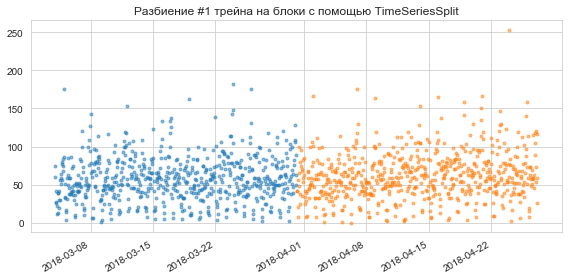

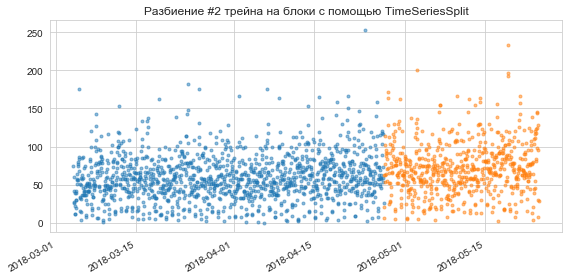

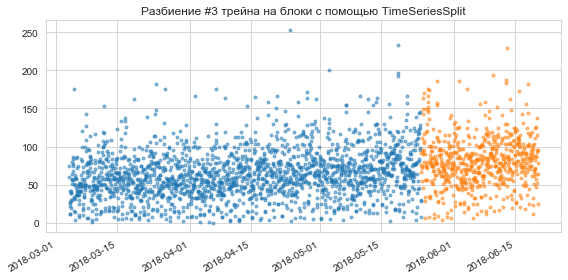

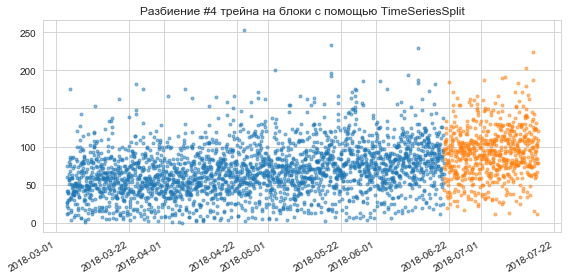

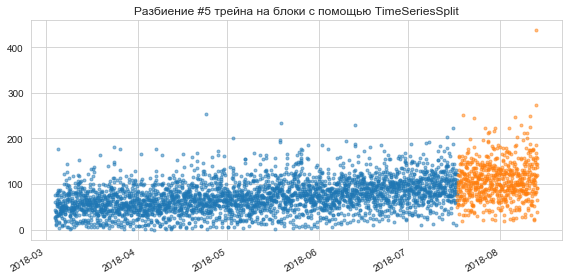

In [39]:
cross_validator = TimeSeriesSplit()
i = 0
for cv_train_index, cv_test_index in cross_validator.split(X_train):
    i+=1
    fig, ax = plt.subplots(figsize=(8,4))
    for indx in [cv_train_index, cv_test_index]:
        plt.plot(df.loc[X_train.index[indx], 'num_orders'], '.', alpha=0.5, label=indx)
        ax.set_title(f'Разбиение #{i} трейна на блоки с помощью TimeSeriesSplit')
        fig.autofmt_xdate()
        plt.tight_layout()

In [40]:
print("Среднее суммарное количество заказов в час в тестовой выборке:", y_test.mean())

print('\nПредсказание медианой трейна:')
dummy = DummyRegressor(strategy='median')
print('На кросс-валидации, RMSE:', cross_val_timeseries(dummy, X_train, y_train))

pred_median = np.ones(y_test.shape) * y_train.median()
print("На тесте, RMSE:", np.sqrt(mean_squared_error(y_test, pred_median)))


print('\nПредсказание предыдущим значением ряда')
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_previous)))

Среднее суммарное количество заказов в час в тестовой выборке: 142.65675675675675

Предсказание медианой трейна:
На кросс-валидации, RMSE: [31.983216752636903, 37.13542782842282, 38.957906277653855, 42.562497034903316, 57.17165785193273]
На тесте, RMSE: 90.47769622129817

Предсказание предыдущим значением ряда
RMSE: 59.94975373571582


In [41]:
trend_rolling_diff = X_train['rolling_mean']-y_train
hour_dict = trend_rolling_diff.groupby(X_train['hour']).mean().to_dict()
weekday_dict = trend_rolling_diff.groupby(X_train['weekday']).mean().to_dict()

X_train['hour'] = X_train['hour'].replace(hour_dict)
X_test['hour'] = X_test['hour'].replace(hour_dict)
X_train['weekday'] = X_train['weekday'].replace(weekday_dict)
X_test['weekday'] = X_test['weekday'].replace(weekday_dict)

In [42]:
X_test.head()

,hour,weekday,lag_1,lag_24,lag_48,lag_72,rolling_mean,diff_1,diff_2
2018-08-16 14:00:00,7.818158,0.244339,69.0,107.0,112.0,102.0,135.083333,-52.0,56.0
2018-08-16 15:00:00,-3.690329,0.244339,64.0,103.0,116.0,175.0,133.291667,-5.0,-60.0
2018-08-16 16:00:00,-29.980195,0.244339,110.0,219.0,111.0,144.0,133.583333,46.0,47.0
2018-08-16 17:00:00,-4.983539,0.244339,190.0,165.0,152.0,152.0,132.375000,80.0,51.0
2018-08-16 18:00:00,15.150720,0.244339,191.0,96.0,98.0,104.0,133.458333,1.0,34.0


In [43]:
X_train.head()

,hour,weekday,lag_1,lag_24,lag_48,lag_72,rolling_mean,diff_1,diff_2
2018-03-04 00:00:00,-57.845348,-1.895906,43.0,163.0,90.0,124.0,53.750000,-20.0,50.0
2018-03-04 01:00:00,-17.318507,-1.895906,75.0,108.0,120.0,85.0,50.083333,32.0,-35.0
2018-03-04 02:00:00,-25.791667,-1.895906,60.0,25.0,75.0,71.0,48.083333,-15.0,52.0
2018-03-04 03:00:00,-16.526840,-1.895906,26.0,64.0,64.0,66.0,48.125000,-34.0,-47.0
2018-03-04 04:00:00,-0.285532,-1.895906,42.0,44.0,20.0,43.0,47.208333,16.0,-19.0


In [44]:
linreg_2 = LinearRegression(normalize=True)

catboost_params_2 = {
    'max_depth': 4, 
    'eta': 0.07,
    'n_estimators': 500,
    'subsample': .6,
    'eval_metric': 'RMSE',
    'verbose':0
             }
catboost_model_2 = CatBoostRegressor(**catboost_params_2)

xgb_params_2 = {
    'max_depth': 4, 
    'eta': 0.02,
    'n_estimators': 500,
    'subsample': 1,
    'eval_metric': 'rmse'
    }
xgb_model_2 = XGBRegressor(**xgb_params_2)

lr_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', linreg_2)
])

cb_pipeline = Pipeline(steps=[
#    ('scaler', StandardScaler()),
    ('model', catboost_model_2)
])

xgb_pipeline = Pipeline(steps=[
#    ('scaler', StandardScaler()),
    ('model', xgb_model_2)
])

In [45]:
print('linreg CV result:', cross_val_timeseries(lr_pipeline, X_test, y_test, metric='rmse', n_splits = 5))
lr_pipeline.fit(X_train, y_train)
model_train_test(lr_pipeline, X_train, X_test, y_train, y_test)
model_train_test(lr_pipeline, X_train, X_test, y_train, y_test, metric='mae')
model_train_test(lr_pipeline, X_train, X_test, y_train, y_test, metric='r2')

linreg CV result: [51.48323842396484, 33.44234992899333, 35.87569163287528, 45.08224481093596, 49.7787501988199]
Предсказание:
rmse обучающей выборки: 22.679945826660248
rmse тестовой выборки:  41.51260057425234
Предсказание:
mae обучающей выборки: 16.918473335858156
mae тестовой выборки:  30.200905514591934
Предсказание:
r2 обучающей выборки: 0.6563405724138647
r2 тестовой выборки:  0.5224708780485279


In [46]:
print('catboost CV result:', cross_val_timeseries(cb_pipeline, X_test, y_test, metric='rmse', n_splits = 5))
cb_pipeline.fit(X_train, y_train)
model_train_test(cb_pipeline, X_train, X_test, y_train, y_test)
model_train_test(cb_pipeline, X_train, X_test, y_train, y_test, metric='mae')
model_train_test(cb_pipeline, X_train, X_test, y_train, y_test, metric='r2')

catboost CV result: [57.57128091888608, 42.252579247327525, 40.55765383533527, 44.99794261597619, 53.92881482706208]
Предсказание:
rmse обучающей выборки: 18.114460596919006
rmse тестовой выборки:  41.05934247834433
Предсказание:
mae обучающей выборки: 13.991338509423427
mae тестовой выборки:  30.561676807723952
Предсказание:
r2 обучающей выборки: 0.7807724908899034
r2 тестовой выборки:  0.5328418164519922


In [47]:
print('catboost CV result:', cross_val_timeseries(xgb_pipeline, X_test, y_test, metric='rmse', n_splits = 5))
xgb_pipeline.fit(X_train, y_train)
model_train_test(xgb_pipeline, X_train, X_test, y_train, y_test)
model_train_test(xgb_pipeline, X_train, X_test, y_train, y_test, metric='mae')
model_train_test(xgb_pipeline, X_train, X_test, y_train, y_test, metric='r2')

catboost CV result: [61.29740399562158, 51.92473452734643, 41.963848741338936, 43.35338776518263, 50.63329681468786]
Предсказание:
rmse обучающей выборки: 18.181880861314156
rmse тестовой выборки:  40.612342073345566
Предсказание:
mae обучающей выборки: 13.941541945488254
mae тестовой выборки:  30.346717277733056
Предсказание:
r2 обучающей выборки: 0.779137567000078
r2 тестовой выборки:  0.5429580631224181


После графического анализа я сделал выбор в пользу линейной регрессии. Бустинги чуть лучше предсказывали всплески заказов в трейне, у регрессии с этим похуже. Но на тесте, на мой взгляд, она даёт более верный прогноз:

In [48]:
y_test_predicted = pd.Series(data=lr_pipeline.predict(X_test), index = y_test.index)
y_train_predicted = pd.Series(data=lr_pipeline.predict(X_train), index = y_train.index)

In [49]:
days_for_analysis = 5

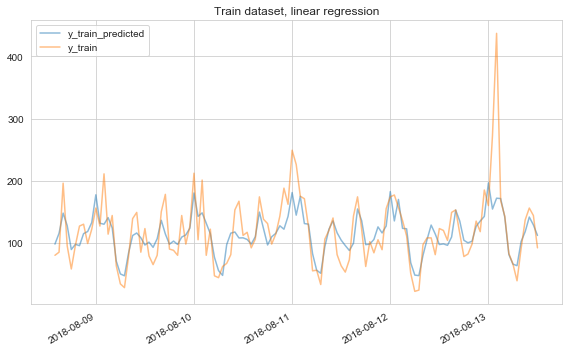

In [50]:
fig = plt.figure(figsize=(8,5))
plt.title('Train dataset, linear regression')
plt.plot(y_train_predicted[-24*days_for_analysis:-1], label='y_train_predicted', alpha=0.5)
plt.plot(y_train[-24*days_for_analysis:-1], label='y_train', alpha=0.5)
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

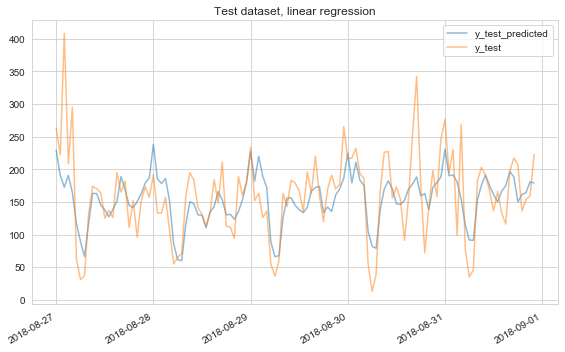

In [51]:
fig = plt.figure(figsize=(8,5))
plt.title('Test dataset, linear regression')
plt.plot(y_test_predicted[-24*days_for_analysis:-1], label='y_test_predicted', alpha=0.5)
plt.plot(y_test[-24*days_for_analysis:-1], label='y_test', alpha=0.5)
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
y_test_predicted = pd.Series(data=xgb_pipeline.predict(X_test), index = y_test.index)
y_train_predicted = pd.Series(data=xgb_pipeline.predict(X_train), index = y_train.index)

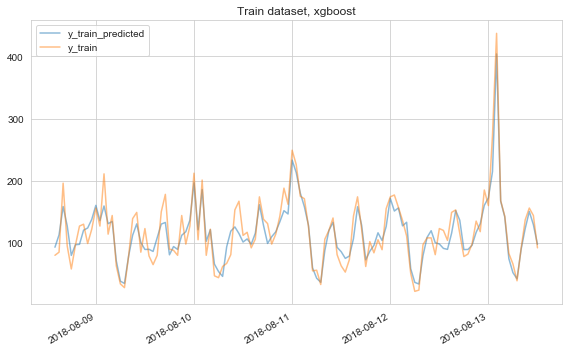

In [53]:
fig = plt.figure(figsize=(8,5))
plt.title('Train dataset, xgboost')
plt.plot(y_train_predicted[-24*days_for_analysis:-1], label='y_train_predicted', alpha=0.5)
plt.plot(y_train[-24*days_for_analysis:-1], label='y_train', alpha=0.5)
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

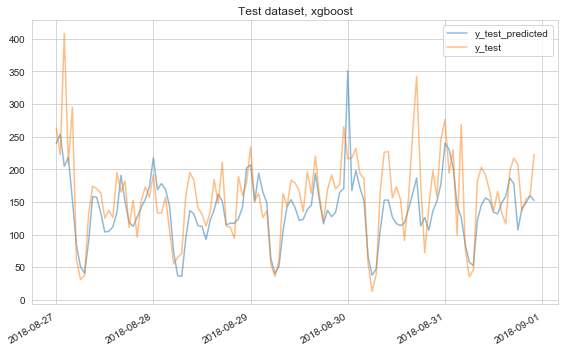

In [54]:
fig = plt.figure(figsize=(8,5))
plt.title('Test dataset, xgboost')
plt.plot(y_test_predicted[-24*days_for_analysis:-1], label='y_test_predicted', alpha=0.5)
plt.plot(y_test[-24*days_for_analysis:-1], label='y_test', alpha=0.5)
fig.autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

<h1 style="color:SteelBlue"> Общий вывод</h1>

Выполнил анализ данных, декомпозицию временного ряда, расчитал корреляции. Предложенный для прогнозирования временной ряд - это ряд с выраженным трендом и двумя сезонностями.

Для решения задачи проекта создал признаки: 
- час и день недели
- 1, 24, 48, 72 лаги
- среднее по скользящему окну за 24 часа
- diff_1 (признак, который показывает, увеличивалось число заказов в последние 2 часа или нет)
- diff_2 (признак, который показывает скорость изменения diff_1)

Обучил и валидировал  линейную регрессию, XGBoost и CatBoost. Выбрал линейную регрессию, т.к. по значениям метрики на валидации она была близка к моделям градиентного спуска. При этом линейная регрессия - более простая, менее склонная к переобучению модель, которая лучше масштабируется (видимо, с лучшим масштабированием как раз связан хороший результат на тесте).

**RMSE на тестовой выборке:  41.51260057425234**